In [ ]:
import os
from PIL import Image

: 

### 테스트로 한개의 이미지로만 전처리를 진행 

In [ ]:
# 특정 이미지 전처리 예시
train_image_path = r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\train\TRAIN_0000.png'

In [ ]:
# 이미지 사이즈 확인 코드
def check_image_size(image_path):
    image = Image.open(image_path)
    return image.size

# TRAIN_0000 이미지 사이즈 확인
original_size = check_image_size(train_image_path)
print(f'Original size of TRAIN_0000: {original_size}')

- 224x224: 대부분의 이미지 분류 모델(예: ResNet, VGG 등)에서 사용되는 표준 크기.
- 256x256: 더 많은 정보 보존을 위해 사용되며, 모델에서 추가적으로 크롭하거나 줄일 수 있음.
- 512x512: 이미지에서 더 많은 디테일이 필요할 때, 특히 작은 세부 사항이 중요한 경우 사용.

In [ ]:
from PIL import Image

# 이미지 리사이즈 함수 정의
def resizing_image(image_path, output_size=(256, 256)):
    image = Image.open(image_path)
    resized_image = image.resize(output_size)
    return resized_image

# 이미지 리사이징 및 저장
resized_image = resizing_image(train_image_path)

### Z-score정규화

#### Z-score 정규화가 가장 먼저 고려되는 이유

1. **이상치 처리**: 극단적인 값에 덜 민감해, 데이터 분포 왜곡을 방지
2. **분포 특성 보존**: 평균 0, 표준편차 1로 변환해 통계적 특성을 유지
3. **모델 성능 향상**: 특징 스케일링으로 거리 기반 알고리즘 성능을 개선
4. **학습 안정성**: 표준 정규분포를 따라 모델 학습이 안정적이며, Gradient Descent 수렴이 빨라짐

#### EXample
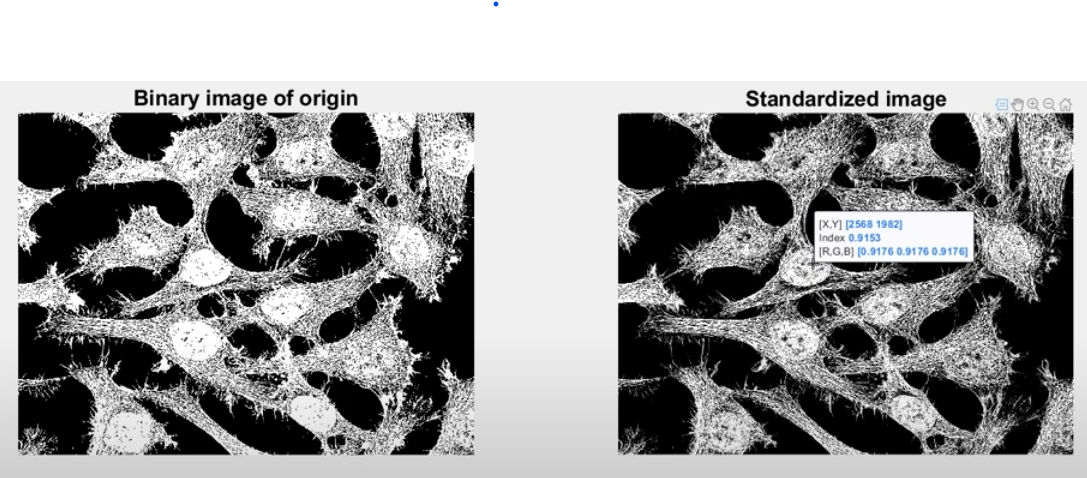


In [ ]:
import numpy as np

# Z-score 정규화 (표준화) 함수 정의
def zscore_normalize_image(image):
    image_array = np.asarray(image).astype(np.float32)
    mean = np.mean(image_array)
    std = np.std(image_array)
    zscore_normalized = (image_array - mean) / std
    return zscore_normalized

In [ ]:
# Z-score 정규화 적용
normalized_image = zscore_normalize_image(resized_image)

# 정규화된 이미지 확인 (선택사항)
print("정규화된 이미지 정보:")
print(f"평균값: {np.mean(normalized_image):.6f}")
print(f"표준편차: {np.std(normalized_image):.6f}")
print(f"최소값: {np.min(normalized_image):.6f}")
print(f"최대값: {np.max(normalized_image):.6f}")

In [ ]:
import matplotlib.pyplot as plt

# 정규화된 이미지 시각화
plt.figure(figsize=(3, 3))
plt.imshow(normalized_image)
plt.title('Z-score Normalized Image')
plt.axis('off')
plt.show()

## 이미지 증강

### 데이터 증강(Data Augmentation) 목적

1. **모델 일반화 성능 향상**: 다양한 패턴 학습으로 새로운 데이터에 대한 예측력을 높임.
2. **데이터 부족 문제 해결**: 제한된 데이터를 변형하여 더 많은 학습 데이터 생성.
3. **과적합 방지**: 변형된 데이터로 학습하여 과적합을 줄이고, 모델의 일반화 능력을 강화.
4. **데이터 편향 줄이기**: 편향된 패턴을 줄이고 더 균형 잡힌 데이터로 학습 가능.

데이터 증강은 특히 이미지, 텍스트, 음성 데이터의 양과 질을 보완하는 중요한 방법이다.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def create_augmented_images(image, num_augmented=5):
    # 의학/생물학 이미지에 적합한 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=15,          # 회전 각도 제한 (세포 이미지는 큰 회전이 불필요)
        width_shift_range=0.1,      # 작은 이동만 허용
        height_shift_range=0.1,
        zoom_range=0.1,            # 약간의 확대/축소만
        brightness_range=[0.9,1.1], # 밝기 변화 제한
        fill_mode='reflect',        # 경계 처리
        horizontal_flip=True,       # 수평 뒤집기 허용
        vertical_flip=True,         # 수직 뒤집기 허용 (세포 이미지는 방향 무관)
        preprocessing_function=None  # 추가 전처리 함수
    )
    
    # 이미지 형태 조정
    x = np.expand_dims(image, axis=0)
    
    # 증강된 이미지 생성
    augmented_images = []
    for i, batch in enumerate(datagen.flow(x, batch_size=1)):
        augmented_images.append(batch[0])
        if i >= num_augmented-1:
            break
            
    return augmented_images

In [ ]:
# 증강된 이미지 시각화
import matplotlib.pyplot as plt

def plot_augmented_images(augmented_images):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(augmented_images):
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Augmented {i+1}')
    plt.show()

In [ ]:
# 함수 실행
augmented_images = create_augmented_images(normalized_image)
plot_augmented_images(augmented_images)

### 현재 문제점
- 이미지의 밝기 변화가 너무 극단적
- 일부 이미지에서 세포 구조의 왜곡이 발생
- 색상 채널간의 균형이 불안정

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화된 이미지
print("Normalized Image Stats:")
print(f"Mean: {np.mean(normalized_image):.2f}")
print(f"Std Dev: {np.std(normalized_image):.2f}")
print(f"Min: {np.min(normalized_image):.2f}")
print(f"Max: {np.max(normalized_image):.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Z-score 정규화 함수 정의
def zscore_normalize_image(image):
    image_array = image.astype(np.float32)
    mean = np.mean(image_array)
    std = np.std(image_array)
    if std == 0:
        std = 1.0
    zscore_normalized = (image_array - mean) / std
    return zscore_normalized

# 이미지 증강을 위한 ImageDataGenerator 정의
datagen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.95, 1.05],
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True
)

# 기존 augmented_images에 대해 추가 증강 수행
additional_augmented_images = []
num_augmented = 5

for img in augmented_images:
    # 배치 차원 추가
    x = np.expand_dims(img, axis=0)
    
    # 증강 수행
    for batch in datagen.flow(x, batch_size=1):
        augmented_image = batch[0].astype(np.float32)
        
        # Z-score 정규화 적용
        zscore_normalized = zscore_normalize_image(augmented_image)
        additional_augmented_images.append(zscore_normalized)
        
        if len(additional_augmented_images) >= num_augmented:
            break
    break

# 증강된 이미지 시각화
plt.figure(figsize=(15, 3))
for i, img in enumerate(additional_augmented_images):
    plt.subplot(1, num_augmented, i + 1)
    
    # 시각화를 위한 스케일링
    img_display = (img - img.min()) / (img.max() - img.min())
    
    if img_display.shape[-1] == 1:
        img_display = img_display.squeeze(-1)
        plt.imshow(img_display, cmap='gray')
    else:
        plt.imshow(img_display)
    
    plt.title(f'Additional Aug {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 전체 훈련데이터로 진행

In [ ]:
# TRAIN_0000부터 TRAIN_6991까지 모든 이미지에 대한 경로 생성
train_image_paths = [
    r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\train\TRAIN_{:04}.png'.format(i)
    for i in range(6992)
]

# 이미지 리사이징

In [ ]:
from PIL import Image

# 이미지 리사이즈 함수 정의
def resizing_image(image_path, output_size=(256, 256)):
    if not os.path.exists(image_path):
        print(f"Warning: File not found - {image_path}")
        return None
    image = Image.open(image_path)
    resized_image = image.resize(output_size)
    return resized_image

# Z-score정규화

In [ ]:
import numpy as np

# Z-score 정규화 (표준화) 함수 정의
def zscore_normalize_image(image):
    image_array = np.asarray(image).astype(np.float32)
    mean = np.mean(image_array)
    std = np.std(image_array)
    zscore_normalized = (image_array - mean) / std
    return zscore_normalized

In [ ]:
# 모든 이미지 리사이즈 및 정규화 반복문
normalized_images = []
for image_path in train_image_paths:
    # 리사이즈 수행
    resized_image = resizing_image(image_path)
    
    # 이미지가 존재하지 않을 경우 건너뜀
    if resized_image is None:
        continue
    
    # 정규화 수행
    normalized_image = zscore_normalize_image(resized_image)
    
    # 결과를 리스트에 저장
    normalized_images.append(normalized_image)

# 모든 이미지가 정규화되었으므로 normalized_images의 길이를 출력
print(f"정규화된 이미지 개수: {len(normalized_images)}")

In [ ]:
import matplotlib.pyplot as plt
import warnings

# 경고 무시 설정
warnings.filterwarnings("ignore", message="Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).")

# 정규화된 이미지 30개 시각화
plt.figure(figsize=(15, 15))
for i in range(10):
    if i >= len(normalized_images):
        break
    plt.subplot(5, 6, i + 1)
    plt.imshow(normalized_images[i], cmap='gray')
    plt.title(f'Image {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

**정규화 이미지 개수 확인**

In [ ]:
print(f"정규화된 이미지 개수: {len(normalized_images)}")

##### 이미지 증강은 Memory Error로 스킵

#### 유전자 발현 이미지 예측 모델 흐름

1. **학습 데이터 준비**  
   - `train.csv`에는 각 학습 이미지의 유전자 발현 정보가 포함되어 있음.

2. **CNN을 사용한 이미지 특징 추출**  
   - CNN을 사용해 각 학습 이미지의 특징을 추출함.

3. **Dense 레이어를 통한 유전자 발현 정보 학습**  
   - 추출된 이미지 특징을 Dense 레이어에 연결하여, 각 이미지에 따른 유전자 발현 정보를 학습함.

4. **테스트 이미지 추론**  
   - 학습된 모델을 사용해 `test.csv`에 있는 각 테스트 이미지의 유전자 발현 정보를 추론함

# train.csv 데이터 입력

In [ ]:
import numpy as np
import pandas as pd

train_df = pd.read_csv(r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\train.csv')
gene_columns = train_df.columns.drop(['ID', 'path'])
labels = train_df[gene_columns].values

In [ ]:
# 예측할 유전자 수 계산
num_genes = labels.shape[1]
print(f"예측할 유전자 수: {num_genes}")

# 모델 입력을 위한 데이터 형태 변환

In [ ]:
# 이미지 데이터를 NumPy 배열로 변환
normalized_images = np.array(normalized_images)

# 이미지 배열의 형태 확인
print(f"이미지 데이터 형태: {normalized_images.shape}")
print(f"라벨 데이터 형태: {labels.shape}")

# 학습 및 검증 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    normalized_images, labels, test_size=0.2, random_state=42
)

##### 이미지와 유전자 발현 데이터 매칭

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 입력 데이터 형태 지정
input_shape = (256, 256, 3)  # 이미지 크기와 채널 수 (컬러 이미지)

# 전처리된 이미지 ID 리스트를 생성
processed_image_ids = [os.path.basename(path).split('.')[0] for path in train_image_paths]

# 'ID'를 인덱스로 설정
train_df.set_index('ID', inplace=True)

# 전처리된 이미지 ID에 해당하는 데이터만 선택하고 순서 맞추기
train_df = train_df.loc[processed_image_ids]

# 라벨 재추출
labels = train_df[gene_columns].values

### CNN modeling

- 합성곱 인공 신경망
- 전통적인 뉴럴 네트워크에 컨볼루셔널 레이어를 붙인 형태
- 컨볼루셔널 레이어를 통해 입력 받은 이미지에 대한 특징(Featuer)을 추출하게 되고 추출한 특징을 기반으로 기존의 뉴럴 네트워크에 이용하여 분류

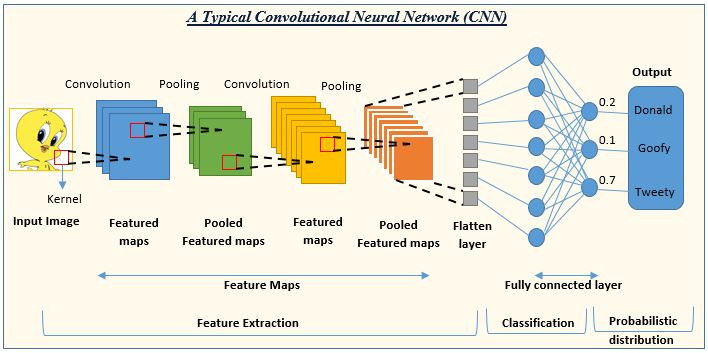

#### CNN을 사용하는 이유

- 이미지를 분류할 때 DNN(Deep Neural Network)의 문제점
- 일반적인 DNN은 1차원 형태의 데이터를 사용 ➡️ 2차원 이상의 데이터가 입력되는 경우는 flatten 시켜서 한줄로 데이터를 변환 후 넣음
- 공간적/지역적 정보가 손실됨

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
# 모델 정의
model = models.Sequential([
    # 이미지를 학습하는 레이어
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # 유전자 발현값을 학습하는 레이어
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_genes)  # 유전자 발현 값 수에 맞게 출력 뉴런 수 설정
])

In [ ]:
# 6. 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 콜백 설정

##### 콜백의 역할

1. **ModelCheckpoint**
   - 학습 중 가장 좋은 성능의 모델 저장
   - 최적의 모델 복원을 위한 지원

2. **EarlyStopping**
   - 과적합 방지를 위한 조기 학습 중단
   - 불필요한 학습 시간 감소

3. **ReduceLROnPlateau**
   - 학습 정체 시 학습률 자동 조절
   - 더 나은 최적점 탐색 지원


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 콜백 설정
checkpoint_path = "birds_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 모델 학습

In [ ]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint_callback, reduce_lr]
)

**실행시간 약 50분**

콜백으로 인한 조기종료

### 모델 성능 평가

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# MAE 그래프
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.show()

##### 모델 학습 평가 요약

1. **손실 곡선 안정성**
   - 초반에 급격히 감소 

2. **Training과 Validation Loss 수렴**
   - 과적합 없이 동일한 수준에서 수렴

3. **평균 절대 오차(MAE) 감소**
   - 초기 급격한 감소 후 수렴

4. **Training과 Validation MAE 수렴**
   - 성능 안정화, 과적합 문제가 발생한것으로 보임


# 테스트 데이터 추론

##### 테스트 데이터 전처리

In [ ]:
# 테스트 이미지 경로 생성
test_image_paths = [
    r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\test\TEST_{:04}.png'.format(i)
    for i in range(2277)
]

In [ ]:
normalized_images = []
test_image_ids = []
for image_path in test_image_paths:
    # 리사이즈 수행
    resized_image = resizing_image(image_path)
    
    # 이미지가 존재하지 않을 경우 건너뜀
    if resized_image is None:
        continue
    
    # 정규화 수행
    normalized_image = zscore_normalize_image(resized_image)
    
    # 결과를 리스트에 저장
    normalized_images.append(normalized_image)

    image_id = os.path.basename(image_path).split('.')[0]
    test_image_ids.append(image_id)

# 모든 이미지가 정규화되었으므로 normalized_images의 길이를 출력
print(f"정규화된 이미지 개수: {len(normalized_images)}")

##### 테스트 데이터 추론

In [ ]:
# 테스트 이미지 데이터를 NumPy 배열로 변환
test_normalized_images = np.array(normalized_images)

# 예측 수행
predictions = model.predict(test_normalized_images)

# 결과를 데이터프로임으로 저장

In [ ]:
# 결과를 데이터프레임으로 저장
sample_submission_path = r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

In [ ]:
# 열 이름 리스트 추출
submission_columns = sample_submission.columns.tolist()

In [ ]:
#  예측 결과를 DataFrame으로 생성
pred_df = pd.DataFrame(predictions, columns=submission_columns[1:])

In [ ]:
# 'ID' 열 추가
pred_df.insert(0, 'ID', test_image_ids)

In [ ]:
# 열 순서 맞추기 (sample_submission.csv와 동일하게)
pred_df = pred_df[sample_submission.columns]

In [ ]:
pred_df

In [ ]:
#  제출 파일 저장
submission_file_path = r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\submission.csv'
pred_df.to_csv(submission_file_path, index=False)

### 모델이 과적합되어 추론이 제대로 진행되지 않음 -> 개선하여 추가 진행